In [129]:
import pickle
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import umap
from scipy import stats
pd.set_option('display.max_rows', 50)
np.set_printoptions(threshold=50)
import joblib
from scipy.stats import fisher_exact
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from matplotlib import cm
import statsmodels.api as sm
import pickle
from joblib import dump
from matplotlib.sankey import Sankey
import plotly.graph_objects as go
from joblib import load
import plotly.io as pio
from math import log10, log2
from scipy.stats import chi2_contingency

In [130]:
def ICD10_code_to_chapter(let):
    if let == 'nan':
        return 'NaN';
    elif let[0] == 'A' or let[0] == 'B':
        return 'A00–B99';
    elif let[0] == 'C' or (let[0] == 'D' and int(let[1])>=0 and int(let[1])<5):
        return 'C00–D48';
    elif let[0] == 'D' and int(let[1])>=5 and int(let[1])<9:
        return 'D50–D89';
    elif let[0] == 'E':
        return 'E00–E90';
    elif let[0] == 'H' and int(let[1])>=0 and int(let[1])<6:
        return 'H00–H59';
    elif let[0] == 'H' and int(let[1])>=6 and int(let[1])<=9:
        return 'H60–H95';
    elif let[0] == 'K':
        return 'K00–K93';
    elif let[0] == 'P':
        return 'P00–P96';
    elif let[0] == 'S' or let[0] == 'T':
        return 'S00–T98';
    elif let[0] in ['V','W','X','Y']:
        return 'V01–Y98';
    elif let[0] in ['F', 'G','I', 'J', 'L', 'M', 'N', 'O','Q','R','Z','U']:
        return '{}00–{}99'.format(let[0], let[0]);
    else:
        return let;
    
def ICDchapter_to_name(chp):
    if chp == 'nan': return 'NaN';
    elif chp == 'A00–B99': return 'Certain infectious and parasitic diseases';
    elif chp == 'C00–D48': return 'Neoplasms';
    elif chp == 'D50–D89': return 'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism';
    elif chp == 'E00–E90': return 'Endocrine, nutritional and metabolic diseases';
    elif chp == 'F00–F99': return 'Mental and behavioural disorders';
    elif chp == 'G00–G99': return 'Diseases of the nervous system';
    elif chp == 'H00–H59': return 'Diseases of the eye and adnexa';
    elif chp == 'H60–H95': return 'Diseases of the ear and mastoid process';
    elif chp == 'I00–I99': return 'Diseases of the circulatory system';
    elif chp == 'J00–J99': return 'Diseases of the respiratory system';
    elif chp == 'K00–K93': return 'Diseases of the digestive system';
    elif chp == 'L00–L99': return 'Diseases of the skin and subcutaneous tissue';
    elif chp == 'M00–M99': return 'Diseases of the musculoskeletal system and connective tissue';
    elif chp == 'N00–N99': return 'Diseases of the genitourinary system';
    elif chp == 'O00–O99': return 'Pregnancy, childbirth and the puerperium';
    elif chp == 'P00–P96': return 'Certain conditions originating in the perinatal period';
    elif chp == 'Q00–Q99': return 'Congenital malformations, deformations and chromosomal abnormalities';
    elif chp == 'R00–R99': return 'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified';
    elif chp == 'S00–T98': return 'Injury, poisoning and certain other consequences of external causes';
    elif chp == 'V01–Y98': return 'External causes of morbidity and mortality';
    elif chp == 'Z00–Z99': return 'Factors influencing health status and contact with health services';
    elif chp == 'U00–U99': return 'Codes for special purposes';
    else: return ' ';

# Load analysis datasets

In [131]:
pwd

'/wynton/protected/home/sirota/ykatsuhara/AD_PCA_Clustering/NoOutlier_AD_DiagnosisName'

In [132]:
alzdiag = pd.read_csv('/wynton/protected/home/sirota/ykatsuhara/AD_PCA_Clustering/ad_diagnosis.csv')
alzdiag['ValueL'] = alzdiag['Value'].apply(lambda x: ICD10_code_to_chapter(str(x)[0:3])) # Get ICD10 Chapte
condiag = pd.read_csv('/wynton/protected/home/sirota/ykatsuhara/AD_PCA_Clustering/control_diagnosis.csv')
condiag['ValueL'] = condiag['Value'].apply(lambda x: ICD10_code_to_chapter(str(x)[0:3]))

# demographics
alzdemo = pd.read_csv('/wynton/protected/home/sirota/ykatsuhara/AD_PCA_Clustering/ad_demographics.csv')
condemo = pd.read_csv('/wynton/protected/home/sirota/ykatsuhara/AD_PCA_Clustering/control_demographics.csv')

In [133]:
condiag.rename(columns={'PatientDurableKey':'PatientID','Value':'ICD10','ValueL':'ICD10_chape'}, inplace=True)

In [134]:
alzdiag.rename(columns={'PatientDurableKey':'PatientID','Value':'ICD10','ValueL':'ICD10_chape'}, inplace=True)

In [135]:
alzdiag = alzdiag[alzdiag['ICD10'].notna()]

In [136]:
alzdiag = alzdiag[~alzdiag['DiagnosisName'].str.contains('alzheimer', flags=re.IGNORECASE)]

In [137]:
with open('df_kmeans_rdm42_traditional5_diagnosis.pkl', 'rb') as f:
    df = pickle.load(f)

In [138]:
df = df[['Cluster_0','Cluster_1', 'Cluster_2', 'Cluster_3','Cluster_4', 'Cluster']]

In [139]:
alzdiag_cluster = alzdiag.join(df, on='PatientID', how='left')

In [140]:
alzdiag_cluster['Cluster'].isna().sum()

0

In [141]:
diagkeys = ['DiagnosisName','l2_name','ICD10']

In [142]:
def countPtsDiagnosis_Dict(df, total_pt):
    ptDiagCount = dict()
    for n in diagkeys:
        diagtemp = df[['PatientID',n]].drop_duplicates() # drop duplicate diagnosis for each patient
        ptDiagCount[n]= pd.DataFrame(diagtemp[n].value_counts()).reset_index()
        ptDiagCount[n].columns = [n,'Count']
        ptDiagCount[n]['Count_r'] = total_pt - ptDiagCount[n]['Count']
    return ptDiagCount

In [143]:
def sigTestCounts(allcounts, n = None, verbose = False, diag = False): 
    ''' 
    combined = sigTestCounts(allcounts, n = None, verbose = False, diag = False)
    Inputs:
        allcounts - dataframe or dictionary.
            Dataframe is of format index with feature name, and 4 columns 
            that make up the contingency table of interest in the order of
            case positive, case negative, control positive, control negative. 
            Each row will be reshaped into a 2x2 contingency table. 
            If dictionary of dataframes, will extract dataframe with key n
        n - default: None. 
            If allcounts is dictionary, n is the key to extract the dataframe
            of interest.
        verbose - default: False
        diag - default: False. If true, will append ICD10 category to the output
            dataframes.
    ----- 
    Outputs:
        combined - dataframe with fisher or chi square stats and odds ratios 
        appended. '''
    # First, for fischer choose any row with less than 5 patients in a category
    if type(allcounts) is dict:
        allcounts = allcounts[n]
    print(n, ': Amount: ', allcounts.shape[0])
    
    temp_less5 = allcounts[allcounts.min(axis=1) < 5]  # take all with counts less than 5
    fisher1 = pd.DataFrame()
    if temp_less5.shape[0] > 0:
        print('\t Fisher Exact for <5 pts in a category, num:', temp_less5.shape[0])
        fisher = temp_less5 \
            .apply(lambda x: stats.fisher_exact(np.array(x).reshape(2,2)), axis=1) \
            .apply(pd.Series)
        fisher.columns = ['OddsRatio', 'pvalue']
        if verbose: print('\t\t fisher:', fisher.shape)

        maxratio = fisher['OddsRatio'][fisher['OddsRatio'] < np.inf].max();
        minratio = fisher['OddsRatio'][fisher['OddsRatio'] > 0].min();
        fisher = fisher.replace(np.inf, maxratio + 1) 
        fisher['log2_oddsratio'] = fisher['OddsRatio'] \
            .apply(lambda x: log2(2**-11) if (x == 0) else log2(x)) # If Odds Ratio = 0, replace about 2^-11

        # Replace 0 p-value with a small non-zero value (min p-value / 2)
        minpvalue = fisher['pvalue'][fisher['pvalue'] > 0].min()
        fisher['pvalue'] = fisher['pvalue'].replace(0, minpvalue / 2)
        
        # Apply -log10 to p-values, making sure there are no negative or zero values
        fisher['-log_pvalue'] = fisher['pvalue'].apply(lambda x: -log10(x) if x > 0 else np.nan)
        
        fisher1 = fisher.merge(temp_less5, how='right', left_index=True, right_index=True)
        if verbose: print('\t\t fisher1:', fisher1.shape)

    # now take the rest of the patients
    temp_more5 = allcounts[allcounts.min(axis=1) >= 5]
    print('\t Chi square for >=5 pts in a category, num:', temp_more5.shape[0])

    fisher = temp_more5 \
        .apply(lambda x: stats.fisher_exact(np.array(x).reshape(2,2)), axis=1) \
        .apply(pd.Series)
    fisher.columns = ['OddsRatio', 'fpvalue']

    maxratio = fisher['OddsRatio'][fisher['OddsRatio'] < np.inf].max()
    minratio = fisher['OddsRatio'][fisher['OddsRatio'] > 0].min()
    fisher = fisher.replace(np.inf, maxratio + 1)
    fisher['log2_oddsratio'] = fisher['OddsRatio'] \
        .apply(lambda x: log2(2**-11) if (x == 0) else log2(x)) # If Odds Ratio = 0, replace about 2^-11
    
    # Replace 0 p-value with a small non-zero value
    fisher['fpvalue'] = fisher['fpvalue'].replace(0, np.nan)
    minpvalue = fisher['fpvalue'].min()
    fisher['fpvalue'].fillna(minpvalue / 2, inplace=True)
    
    # Apply -log10 to fp-values, ensuring no zero or negative values
    fisher['-log_fpvalue'] = fisher['fpvalue'].apply(lambda x: -np.log10(x) if x > 0 else np.nan)

    if verbose: print('\t\t fisher', fisher.shape)

    chisquare = temp_more5.apply(lambda x: chi2_contingency(np.array(x).reshape(2,2)), axis=1) \
                          .apply(pd.Series)
    chisquare.columns = ['chistat', 'pvalue', 'dof', 'expected']
    chisquare = chisquare.merge(temp_more5, how='right', left_index=True, right_index=True)
    
    # Replace 0 p-value with the smallest non-zero p-value divided by 2
    minpvalue = chisquare['pvalue'][chisquare['pvalue'] > 0].min()
    chisquare['pvalue'] = chisquare['pvalue'].replace(0, minpvalue / 2)
    chisquare['-log_pvalue'] = chisquare['pvalue'].apply(lambda x: -log10(x))
    if verbose: print('\t\t chisquare:', chisquare.shape)

    combined = chisquare.merge(fisher, left_index=True, right_index=True, how='left')
    combined = combined.append(fisher1)
    if verbose: print('\t\t combined 1:', combined.shape)
    
    if diag:
        temp = alzdiag[[n, 'ICD10_chape']].drop_duplicates()  # create mapping
        temp = temp[temp['ICD10_chape'] != 'NaN'].groupby(n)['ICD10_chape'].apply(list)
        combined = combined.merge(temp, how='left', left_index=True, right_index=True, suffixes=(False, False))
        if verbose: print('\t\t combined 2:', combined.shape)

    print('\t Final num: ', combined.shape[0])
    
    return combined


In [144]:
def sigTestCountsDict(allcountsdict, dictkeys, verbose = False, diag = False):
    ''' combined = sigTestCountsDict(allcountsdict, verbose = False, diag = False)
    Inputs:
    allcountsdict - dictionary of dataframes.
        Each dataframe is of format index with feature name, and 4 columns 
        that make up the contingency table of interest in the order of
        case positive, case negative, control positive, control negative. 
        Each row will be reshaped into a 2x2 contingency table. 
    dictkeys - iterable object with the keys of allcountsdict.
    verbose - default: False
    diag - default: False. If true, will append ICD10 category to the output
        dataframes.
    ----
    Outputs: 
    combined - dictionary of dataframes with fisher or chi square 
    stats and odds ratios appended to each dataframe. '''
    
    combineddict = dict()
    for n in dictkeys:
        print('Significance testing on ', n)
        combineddict[n] = sigTestCounts(allcountsdict, n,verbose= verbose,diag = diag)
    return combineddict

In [145]:
alzdiag_cluster['isAD'] = 1

In [146]:
alzdiag_cluster.columns

Index(['PatientID', 'DiagnosisKey', 'DiagnosisName', 'ICD10', 'l2_name',
       'l3_name', 'Sex', 'BirthDate', 'minAge', 'ICD10_chape', 'Cluster_0',
       'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster', 'isAD'],
      dtype='object')

In [147]:
alldiag_cluster = alzdiag_cluster

# Cluster 0 vs. Other Clusters

In [148]:
focus_cluster = 'Cluster_0'

In [149]:
alldiag_f_cluster = alldiag_cluster[alldiag_cluster[focus_cluster]==1]
alldiag_nonf_cluster = alldiag_cluster[alldiag_cluster[focus_cluster]==0]

In [150]:
alldiag_f_cluster['PatientID'].nunique()

5161

In [151]:
alldiag_nonf_cluster['PatientID'].nunique()

3202

In [152]:
total_f = alldiag_f_cluster['PatientID'].nunique() #Total cluster0 patients
total_nonf = alldiag_nonf_cluster['PatientID'].nunique() #Total cluster1 patients

In [153]:
countDiagnosis_f = countPtsDiagnosis_Dict(alldiag_f_cluster, total_f)

In [154]:
countDiagnosis_nonf = countPtsDiagnosis_Dict(alldiag_nonf_cluster, total_nonf)

In [155]:
alldiag_f_cluster

,PatientID,DiagnosisKey,DiagnosisName,ICD10,l2_name,l3_name,Sex,BirthDate,minAge,ICD10_chape,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster,isAD
0,D000D5B83D9620,170467,CHF (congestive heart failure) (HCC),I50.9,Other forms of heart disease (I30-I52),Heart failure,Female,1929-11-11,80.0,I00–I99,1.0,0.0,0.0,0.0,0.0,0,1
1,D000D5B83D9620,754041,Dysuria,R30.0,Symptoms and signs involving the genitourinary...,Pain associated with micturition,Female,1929-11-11,81.0,R00–R99,1.0,0.0,0.0,0.0,0.0,0,1
2,D000D5B83D9620,762318,Mitral regurgitation,I34.0,Other forms of heart disease (I30-I52),Nonrheumatic mitral valve disorders,Female,1929-11-11,NaN,I00–I99,1.0,0.0,0.0,0.0,0.0,0,1
3,D000D5B83D9620,889461,Hyperlipidemia,E78.5,Metabolic disorders (E70-E88),Disorders of lipoprotein metabolism and other ...,Female,1929-11-11,80.0,E00–E90,1.0,0.0,0.0,0.0,0.0,0,1
4,D000D6884BD199,323456,Memory loss,R41.3,"Symptoms and signs involving cognition, percep...",Other symptoms and signs involving cognitive f...,Male,1930-02-27,83.0,R00–R99,1.0,0.0,0.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553893,DFF8BCF1650C22,391671,Unspecified condition of brain,G93.9,Other disorders of the nervous system (G89-G99),Other disorders of brain,Male,1950-11-03,52.0,G00–G99,1.0,0.0,0.0,0.0,0.0,0,1
553940,DFFF132A593DAB,80251,"Disorientation, unspecified",R41.0,"Symptoms and signs involving cognition, percep...",Other symptoms and signs involving cognitive f...,Female,1930-04-05,88.0,R00–R99,1.0,0.0,0.0,0.0,0.0,0,1
553941,DFFF132A593DAB,661177,Abnormality of gait,R26.9,Symptoms and signs involving the nervous and m...,Abnormalities of gait and mobility,Female,1930-04-05,82.0,R00–R99,1.0,0.0,0.0,0.0,0.0,0,1
553942,DFFF132A593DAB,662173,Left foot pain,M79.672,Other soft tissue disorders (M70-M79),"Other and unspecified soft tissue disorders, n...",Female,1930-04-05,88.0,M00–M99,1.0,0.0,0.0,0.0,0.0,0,1


In [156]:
countDiagnosis_f

{'DiagnosisName':                                            DiagnosisName  Count  Count_r
 0      Dementia in other diseases classified elsewher...   1298     3863
 1                                            Memory loss    828     4333
 2                     Unspecified essential hypertension    822     4339
 3                                           Hypertension    795     4366
 4                   Mild cognitive impairment, so stated    735     4426
 ...                                                  ...    ...      ...
 12999  Personal history of other malignant neoplasms ...      1     5160
 13000  Rheumatoid arthritis of multiple sites without...      1     5160
 13001  Insomnia due to medical condition classified e...      1     5160
 13002             Forehead laceration, initial encounter      1     5160
 13003                           Diabetes insipidus (HCC)      1     5160
 
 [13004 rows x 3 columns],
 'l2_name':                                                l2_name

In [157]:
# Create dictionary of dataframes of contingency table for each diagnosis
alldiagcount = dict() 

jointype = 'outer' # outer join allows us to have contingency table with 0 as entries

for n in diagkeys:
    alldiagcount[n] = countDiagnosis_f[n].merge(countDiagnosis_nonf[n], how = jointype, on = n, suffixes=('_c0','_nonc0'))
    alldiagcount[n] = alldiagcount[n].set_index(n)
    if jointype == 'outer': # replace nan's
        nanreplace = dict(zip( list(alldiagcount[n].columns) , [0,total_f,0,total_nonf] ))
        alldiagcount[n] =  alldiagcount[n].fillna(value=nanreplace)

In [158]:
# compute p-values.
chitest_count = sigTestCountsDict(alldiagcount, diagkeys, verbose = 1, diag = True)

Significance testing on  DiagnosisName
DiagnosisName : Amount:  33031
	 Fisher Exact for <5 pts in a category, num: 30732
		 fisher: (30732, 2)
		 fisher1: (30732, 8)
	 Chi square for >=5 pts in a category, num: 2299
		 fisher (2299, 4)
		 chisquare: (2299, 9)
		 combined 1: (33031, 13)
		 combined 2: (33031, 14)
	 Final num:  33031
Significance testing on  l2_name
l2_name : Amount:  270
	 Fisher Exact for <5 pts in a category, num: 58
		 fisher: (58, 2)
		 fisher1: (58, 8)
	 Chi square for >=5 pts in a category, num: 212
		 fisher (212, 4)
		 chisquare: (212, 9)
		 combined 1: (270, 13)
		 combined 2: (270, 14)
	 Final num:  270
Significance testing on  ICD10
ICD10 : Amount:  10450
	 Fisher Exact for <5 pts in a category, num: 8781
		 fisher: (8781, 2)
		 fisher1: (8781, 8)
	 Chi square for >=5 pts in a category, num: 1669
		 fisher (1669, 4)
		 chisquare: (1669, 9)
		 combined 1: (10450, 13)
		 combined 2: (10450, 14)
	 Final num:  10450


In [159]:
# Categorize diagnosis based upon significance
for n in diagkeys:
    bc = .05/chitest_count[n].shape[0] # Bonferonni corrected p-value
    print('bc:',bc)
    
    sig = np.full(shape = (chitest_count[n].shape[0],), fill_value = 'Not Significant') 
    sig[chitest_count[n]['pvalue']<bc] = 'Significant'
    mask = (chitest_count[n]['pvalue']<bc) & (chitest_count[n]['log2_oddsratio']>1)
    sig[mask] = 'Cluster0'
    mask = (chitest_count[n]['pvalue']<bc) & (chitest_count[n]['log2_oddsratio']<-1)
    sig[mask] = 'Other Clusters'
    
    chitest_count[n]['sig'] = sig
    
    # Save the file as CSV
    chitest_count[n][(chitest_count[n]['sig'] != 'Not Significant')].to_csv(f'sig_diagnosis_stats_AD_c0_other_{n}_volcano.csv', index=True)

    # Print the summary
    print(chitest_count[n]['sig'].value_counts())
    print('\n')

bc: 1.51372952680815e-06
Not Significant    30369
Other Clusters      2653
Significant            7
Cluster0               2
Name: sig, dtype: int64


bc: 0.0001851851851851852
Other Clusters     194
Not Significant     73
Significant          3
Name: sig, dtype: int64


bc: 4.784688995215312e-06
Not Significant    8712
Other Clusters     1729
Significant           8
Cluster0              1
Name: sig, dtype: int64




In [160]:
# save
import pickle 
pickle.dump(chitest_count, open('all_diagnosis_stats_c0_other_AD_volcano.picke', 'wb'))

In [161]:
# カスタムカラーマップの定義
custom_palette = {
    "Not Significant": "#949494",
    "Significant": "#51A0D5",
    "Cluster0": "#EC719E",
    "Other Clusters": "#2CB97C"
}

# カスタムカラーマップを使用するためのリスト
custom_colors = ["#949494", "#51A0D5", "#EC719E", "#2CB97C"]

In [162]:
from adjustText import adjust_text

In [163]:
# データフレームを保存するための辞書
label_data_dict = {}

for n in diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()
 
    # 統計的に有意を取得
    significant_df = df[df['sig'] != 'Not Significant'].copy()

    # ラベルデータを保存
    label_data = [
        {'Label': row['index'], 'X': row['log2_oddsratio'], 'Y': row['-log_pvalue']}
        for idx, row in significant_df.iterrows()
    ]

    # pandas DataFrameに変換
    df_labels = pd.DataFrame(label_data)

    df_labels.to_csv(f'c0_label_positions_AD_{n}_volcano.csv', index=False)

In [164]:
label_positions_df = pd.read_csv('c0_label_positions_AD_ICD10_volcano.csv')
mapping_df = pd.read_csv('ICD10_Disease_Mapping.csv')

In [165]:
# Initialize flag column with 0
label_positions_df['flag'] = 0

# Create a mapping column for the disease name
label_positions_df['mapping'] = ""


In [166]:
# Iterate through the labels and set flag to 1 and mapping to the disease name if partial match is found
for idx, row in label_positions_df.iterrows():
    for mapping_idx, mapping_row in mapping_df.iterrows():
        if mapping_row['ICD10_Code'] in row['Label']:  # Partial match check
            label_positions_df.at[idx, 'flag'] = 1
            label_positions_df.at[idx, 'mapping'] = mapping_row['Disease_Name']
            break

In [167]:
# First, filter the rows where flag is 1
flagged_df = label_positions_df[label_positions_df['flag'] == 1]

# Group by 'mapping' (Disease_Name), and for each group, find the row with the max 'X'
max_X_idx = flagged_df.groupby('mapping')['X'].idxmax()

# Now, update the flag in the original DataFrame
# First, set all flags to 0 for rows where flag is currently 1
label_positions_df.loc[label_positions_df['flag'] == 1, 'flag'] = 0

# Set flag to 1 for the rows with the max 'X' in each group
label_positions_df.loc[max_X_idx, 'flag'] = 1

In [168]:
flagged_df = label_positions_df[label_positions_df['flag'] == 1]

# Sort the flagged rows by 'X' in descending order and get the top 10
top_10_idx = flagged_df.nlargest(10, 'X').index

# Now, update the flag in the original DataFrame
# First, set all flags to 0 for rows where flag is currently 1
label_positions_df.loc[label_positions_df['flag'] == 1, 'flag'] = 0

# Set flag to 1 for the top 10 rows with the largest 'X' values
label_positions_df.loc[top_10_idx, 'flag'] = 1

In [169]:
label_positions_df

,Label,X,Y,flag,mapping
0,I10,-3.501890,311.141798,0,Essential (primary) hypertension
1,F02.80,-0.580468,17.283751,1,Dementia in other diseases classified elsewhere
2,F03.90,-2.259136,241.876775,0,Unspecified dementia
3,R41.3,-1.255849,67.037987,0,
4,E78.5,-2.636000,300.520953,0,Disorders of lipoprotein metabolism and other ...
...,...,...,...,...,...
1733,B02.22,-11.000000,5.426771,0,
1734,S50.10XA,-11.000000,5.426771,0,
1735,D68.4,-11.000000,5.426771,0,
1736,B95.1,-11.000000,5.426771,0,


In [170]:
label_positions_df.to_csv(f'c0_label_positions_AD_ICD10_volcano.csv', index=False)

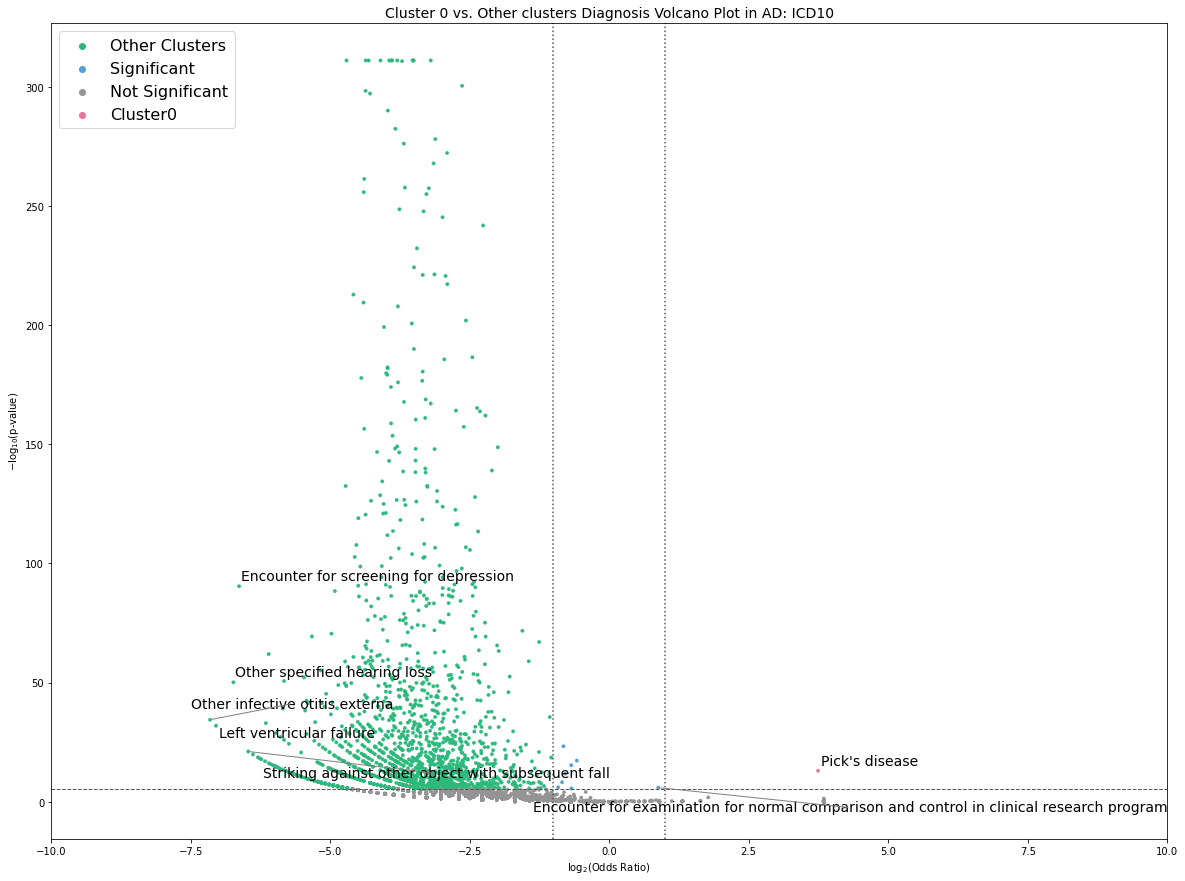

In [171]:
# マッピングファイルを読み込む
df_labels = pd.read_csv('c0_label_positions_AD_ICD10_map.csv')

plot_diagkeys = ['ICD10']

# データフレームを保存するための辞書
label_data_dict = {}

for n in plot_diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()

    # プロットの設定
    fig, ax = plt.figure(figsize=(20, 15)), plt.gca()
    g = sns.scatterplot(data=df, x='log2_oddsratio', y='-log_pvalue', 
                        hue='sig', palette=custom_palette, 
                        edgecolor=None, s=12, ax=ax)
    
    plt.xlim([-10, 10])
    plt.axhline(-np.log10(bc), linestyle='--', color='#555555', linewidth=1)
    plt.axvline(1, color='#555555', linestyle=':')
    plt.axvline(-1, color='#555555', linestyle=':')
    plt.xlabel(r'$\log_2$(Odds Ratio)')
    plt.ylabel(r'$-\log_{10}$(p-value)')
    plt.legend(loc='upper left', prop={'size': 16})  # 凡例を左上に移動
    plt.title('Cluster 0 vs. Other clusters Diagnosis Volcano Plot in AD: ' + n, fontsize=14)
    
    # 保存されたラベルを再プロット
    texts = []
    for idx, row in df_labels.iterrows():
        if row['flag'] == 1:
            label_text = row['mapping']
            x_pos = row['X']
            y_pos = row['Y']
        
            # テキストラベルを再度プロット (フォントサイズを少し小さく)
            text = ax.text(x_pos, y_pos, label_text, fontsize=14, ha='left', va='center')
            texts.append(text)

    # adjustTextでラベルの重なりを解消 (X方向にも動かすように変更)
    adjust_text(texts, 
                only_move={'points': 'xy', 'text': 'xy'},  # X方向とY方向両方に移動
                arrowprops=dict(arrowstyle='-', color='gray', lw=1.0),  # ラベルからポイントに矢印を描画
                expand_points=(1.3, 1.3),  # ポイント周りのスペースを広げる
                expand_text=(1.3, 1.3),  # テキスト周りのスペースを広げる
                force_text=2.0,  # ラベルをより大きく移動させる
                force_points=1.5,  # ポイントも少し動かす
                lim_points_text=1.5,  # ポイントとテキストの最小距離を増やす
                lim_text_text=2.0,  # テキスト同士の最小距離を増やす
                avoid_self=True,  # 自分自身との重なりを避ける
                ensure_inside_axes=True)  # プロット内に収めるようにする


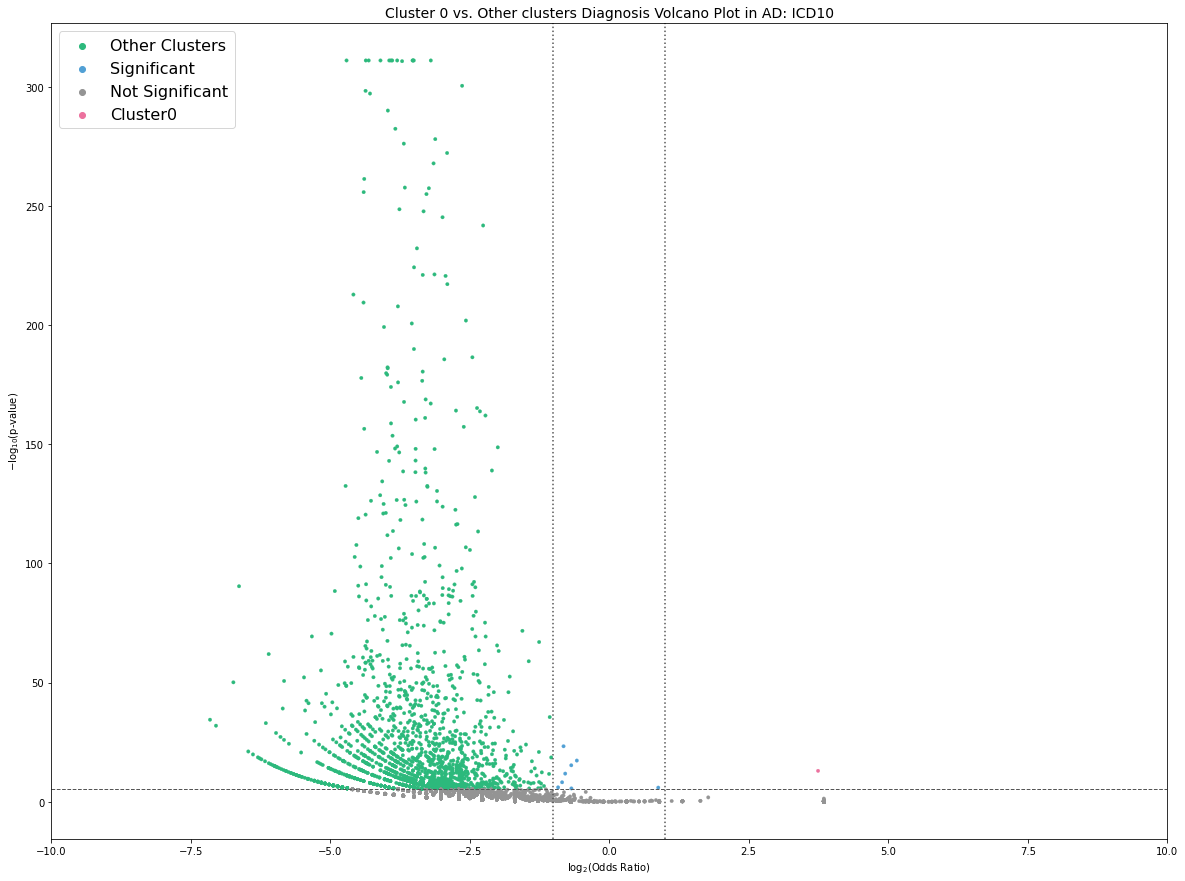

In [172]:

plot_diagkeys = ['ICD10']

# データフレームを保存するための辞書
label_data_dict = {}

for n in plot_diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()

    # プロットの設定
    fig, ax = plt.figure(figsize=(20, 15)), plt.gca()
    g = sns.scatterplot(data=df, x='log2_oddsratio', y='-log_pvalue', 
                        hue='sig', palette=custom_palette, 
                        edgecolor=None, s=12, ax=ax)
    
    plt.xlim([-10, 10])
    plt.axhline(-np.log10(bc), linestyle='--', color='#555555', linewidth=1)
    plt.axvline(1, color='#555555', linestyle=':')
    plt.axvline(-1, color='#555555', linestyle=':')
    plt.xlabel(r'$\log_2$(Odds Ratio)')
    plt.ylabel(r'$-\log_{10}$(p-value)')
    plt.legend(loc='upper left', prop={'size': 16})  # 凡例を左上に移動
    plt.title('Cluster 0 vs. Other clusters Diagnosis Volcano Plot in AD: ' + n, fontsize=14)
    

    plt.show()

# Cluster 1 vs Other Clusters

In [173]:
focus_cluster = 'Cluster_1'

In [174]:
alldiag_f_cluster = alldiag_cluster[alldiag_cluster[focus_cluster]==1]
alldiag_nonf_cluster = alldiag_cluster[alldiag_cluster[focus_cluster]==0]

In [175]:
alldiag_f_cluster['PatientID'].nunique()

328

In [176]:
alldiag_nonf_cluster['PatientID'].nunique()

8035

In [177]:
total_f = alldiag_f_cluster['PatientID'].nunique() #Total cluster0 patients
total_nonf = alldiag_nonf_cluster['PatientID'].nunique() #Total cluster1 patients

In [178]:
countDiagnosis_f = countPtsDiagnosis_Dict(alldiag_f_cluster, total_f)

In [179]:
countDiagnosis_nonf = countPtsDiagnosis_Dict(alldiag_nonf_cluster, total_nonf)

In [180]:
# Create dictionary of dataframes of contingency table for each diagnosis
alldiagcount = dict() 

jointype = 'outer' # outer join allows us to have contingency table with 0 as entries

for n in diagkeys:
    alldiagcount[n] = countDiagnosis_f[n].merge(countDiagnosis_nonf[n], how = jointype, on = n, suffixes=('_c1','_nonc1'))
    alldiagcount[n] = alldiagcount[n].set_index(n)
    if jointype == 'outer': # replace nan's
        nanreplace = dict(zip( list(alldiagcount[n].columns) , [0,total_f,0,total_nonf] ))
        alldiagcount[n] =  alldiagcount[n].fillna(value=nanreplace)

In [181]:
# compute p-values.
chitest_count = sigTestCountsDict(alldiagcount, diagkeys, verbose = 1, diag = True)

Significance testing on  DiagnosisName
DiagnosisName : Amount:  33031
	 Fisher Exact for <5 pts in a category, num: 29441
		 fisher: (29441, 2)
		 fisher1: (29441, 8)
	 Chi square for >=5 pts in a category, num: 3590
		 fisher (3590, 4)
		 chisquare: (3590, 9)
		 combined 1: (33031, 13)
		 combined 2: (33031, 14)
	 Final num:  33031
Significance testing on  l2_name
l2_name : Amount:  270
	 Fisher Exact for <5 pts in a category, num: 72
		 fisher: (72, 2)
		 fisher1: (72, 8)
	 Chi square for >=5 pts in a category, num: 198
		 fisher (198, 4)
		 chisquare: (198, 9)
		 combined 1: (270, 13)
		 combined 2: (270, 14)
	 Final num:  270
Significance testing on  ICD10
ICD10 : Amount:  10450
	 Fisher Exact for <5 pts in a category, num: 8337
		 fisher: (8337, 2)
		 fisher1: (8337, 8)
	 Chi square for >=5 pts in a category, num: 2113
		 fisher (2113, 4)
		 chisquare: (2113, 9)
		 combined 1: (10450, 13)
		 combined 2: (10450, 14)
	 Final num:  10450


In [182]:
# Categorize diagnosis based upon significance
for n in diagkeys:
    bc = .05/chitest_count[n].shape[0] # Bonferonni corrected p-value
    print('bc:',bc)
    
    sig = np.full(shape = (chitest_count[n].shape[0],), fill_value = 'Not Significant') 
    sig[chitest_count[n]['pvalue']<bc] = 'Significant'
    mask = (chitest_count[n]['pvalue']<bc) & (chitest_count[n]['log2_oddsratio']>1)
    sig[mask] = 'Cluster1'
    mask = (chitest_count[n]['pvalue']<bc) & (chitest_count[n]['log2_oddsratio']<-1)
    sig[mask] = 'Other Clusters'
    
    chitest_count[n]['sig'] = sig
    print(chitest_count[n]['sig'].value_counts())
    
    # Save the file as CSV
    chitest_count[n][(chitest_count[n]['sig'] != 'Not Significant')].to_csv(f'sig_diagnosis_stats_AD_c1_other_{n}_volcano.csv', index=True)

    
    print('\n')


bc: 1.51372952680815e-06
Not Significant    29717
Cluster1            3314
Name: sig, dtype: int64


bc: 0.0001851851851851852
Cluster1           196
Not Significant     74
Name: sig, dtype: int64


bc: 4.784688995215312e-06
Not Significant    8537
Cluster1           1913
Name: sig, dtype: int64




In [183]:
# save
import pickle 
pickle.dump(chitest_count, open('all_diagnosis_stats_c1_other_AD_volcano.picke', 'wb'))

In [184]:
# データフレームを保存するための辞書
label_data_dict = {}

for n in diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()
 
    # 統計的に有意を取得
    significant_df = df[df['sig'] != 'Not Significant'].copy()

    # ラベルデータを保存
    label_data = [
        {'Label': row['index'], 'X': row['log2_oddsratio'], 'Y': row['-log_pvalue']}
        for idx, row in significant_df.iterrows()
    ]

    # pandas DataFrameに変換
    df_labels = pd.DataFrame(label_data)

    df_labels.to_csv(f'c1_label_positions_AD_{n}_volcano.csv', index=False)

In [185]:
# カスタムカラーマップの定義
custom_palette = {
    "Not Significant": "#949494",
    "Significant": "#51A0D5",
    "Cluster1": "#EC719E",
    "Other Clusters": "#2CB97C"
}

# カスタムカラーマップを使用するためのリスト
custom_colors = ["#949494", "#51A0D5", "#EC719E", "#2CB97C"]

In [186]:
label_positions_df = pd.read_csv('c1_label_positions_AD_ICD10_volcano.csv')
mapping_df = pd.read_csv('ICD10_Disease_Mapping.csv')

In [187]:
# Initialize flag column with 0
label_positions_df['flag'] = 0

# Create a mapping column for the disease name
label_positions_df['mapping'] = ""


In [188]:
# Iterate through the labels and set flag to 1 and mapping to the disease name if partial match is found
for idx, row in label_positions_df.iterrows():
    for mapping_idx, mapping_row in mapping_df.iterrows():
        if mapping_row['ICD10_Code'] in row['Label']:  # Partial match check
            label_positions_df.at[idx, 'flag'] = 1
            label_positions_df.at[idx, 'mapping'] = mapping_row['Disease_Name']
            break

In [189]:
# First, filter the rows where flag is 1
flagged_df = label_positions_df[label_positions_df['flag'] == 1]

# Group by 'mapping' (Disease_Name), and for each group, find the row with the max 'X'
max_X_idx = flagged_df.groupby('mapping')['X'].idxmax()

# Now, update the flag in the original DataFrame
# First, set all flags to 0 for rows where flag is currently 1
label_positions_df.loc[label_positions_df['flag'] == 1, 'flag'] = 0

# Set flag to 1 for the rows with the max 'X' in each group
label_positions_df.loc[max_X_idx, 'flag'] = 1

In [190]:
flagged_df = label_positions_df[label_positions_df['flag'] == 1]

# Sort the flagged rows by 'X' in descending order and get the top 10
top_10_idx = flagged_df.nlargest(10, 'X').index

# Now, update the flag in the original DataFrame
# First, set all flags to 0 for rows where flag is currently 1
label_positions_df.loc[label_positions_df['flag'] == 1, 'flag'] = 0

# Set flag to 1 for the top 10 rows with the largest 'X' values
label_positions_df.loc[top_10_idx, 'flag'] = 1

In [191]:
label_positions_df.to_csv(f'c1_label_positions_AD_ICD10.csv', index=False)

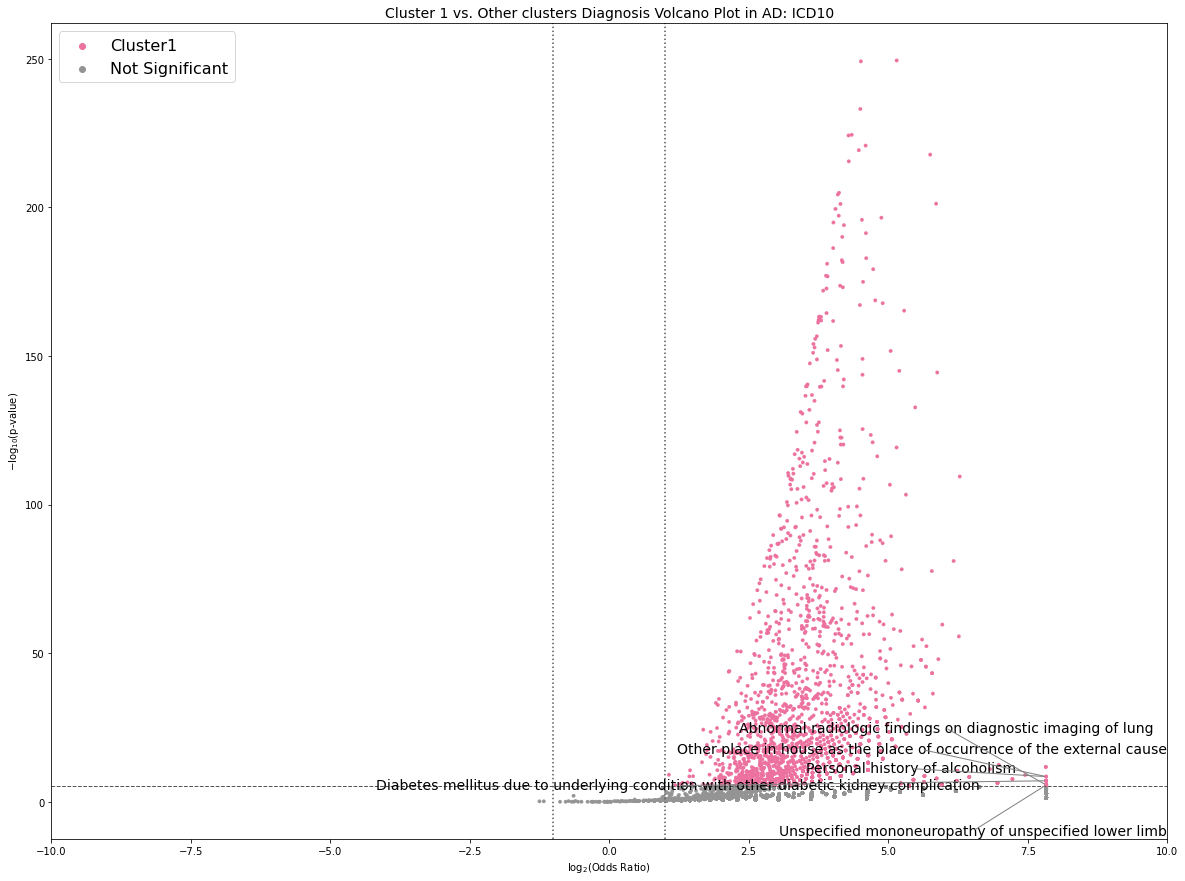

In [192]:
# マッピングファイルを読み込む
df_labels = pd.read_csv('c1_label_positions_AD_ICD10_map.csv')

plot_diagkeys = ['ICD10']

# データフレームを保存するための辞書
label_data_dict = {}

for n in plot_diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()

    # プロットの設定
    fig, ax = plt.figure(figsize=(20, 15)), plt.gca()
    g = sns.scatterplot(data=df, x='log2_oddsratio', y='-log_pvalue', 
                        hue='sig', palette=custom_palette, 
                        edgecolor=None, s=12, ax=ax)
    
    plt.xlim([-10, 10])
    plt.axhline(-np.log10(bc), linestyle='--', color='#555555', linewidth=1)
    plt.axvline(1, color='#555555', linestyle=':')
    plt.axvline(-1, color='#555555', linestyle=':')
    plt.xlabel(r'$\log_2$(Odds Ratio)')
    plt.ylabel(r'$-\log_{10}$(p-value)')
    plt.legend(loc='upper left', prop={'size': 16})  # 凡例を左上に移動
    plt.title('Cluster 1 vs. Other clusters Diagnosis Volcano Plot in AD: ' + n, fontsize=14)
    
    # 保存されたラベルを再プロット
    texts = []
    for idx, row in df_labels.iterrows():
        if row['flag'] == 1:
            label_text = row['mapping']
            x_pos = row['X']
            y_pos = row['Y']
        
            # テキストラベルを再度プロット (フォントサイズを少し小さく)
            text = ax.text(x_pos, y_pos, label_text, fontsize=14, ha='left', va='center')
            texts.append(text)

    # adjustTextでラベルの重なりを解消 (X方向にも動かすように変更)
    adjust_text(texts, 
                only_move={'points': 'xy', 'text': 'xy'},  # X方向とY方向両方に移動
                arrowprops=dict(arrowstyle='-', color='gray', lw=1.0),  # ラベルからポイントに矢印を描画
                expand_points=(1.3, 1.3),  # ポイント周りのスペースを広げる
                expand_text=(1.3, 1.3),  # テキスト周りのスペースを広げる
                force_text=2.0,  # ラベルをより大きく移動させる
                force_points=1.5,  # ポイントも少し動かす
                lim_points_text=1.5,  # ポイントとテキストの最小距離を増やす
                lim_text_text=2.0,  # テキスト同士の最小距離を増やす
                avoid_self=True,  # 自分自身との重なりを避ける
                ensure_inside_axes=True)  # プロット内に収めるようにする


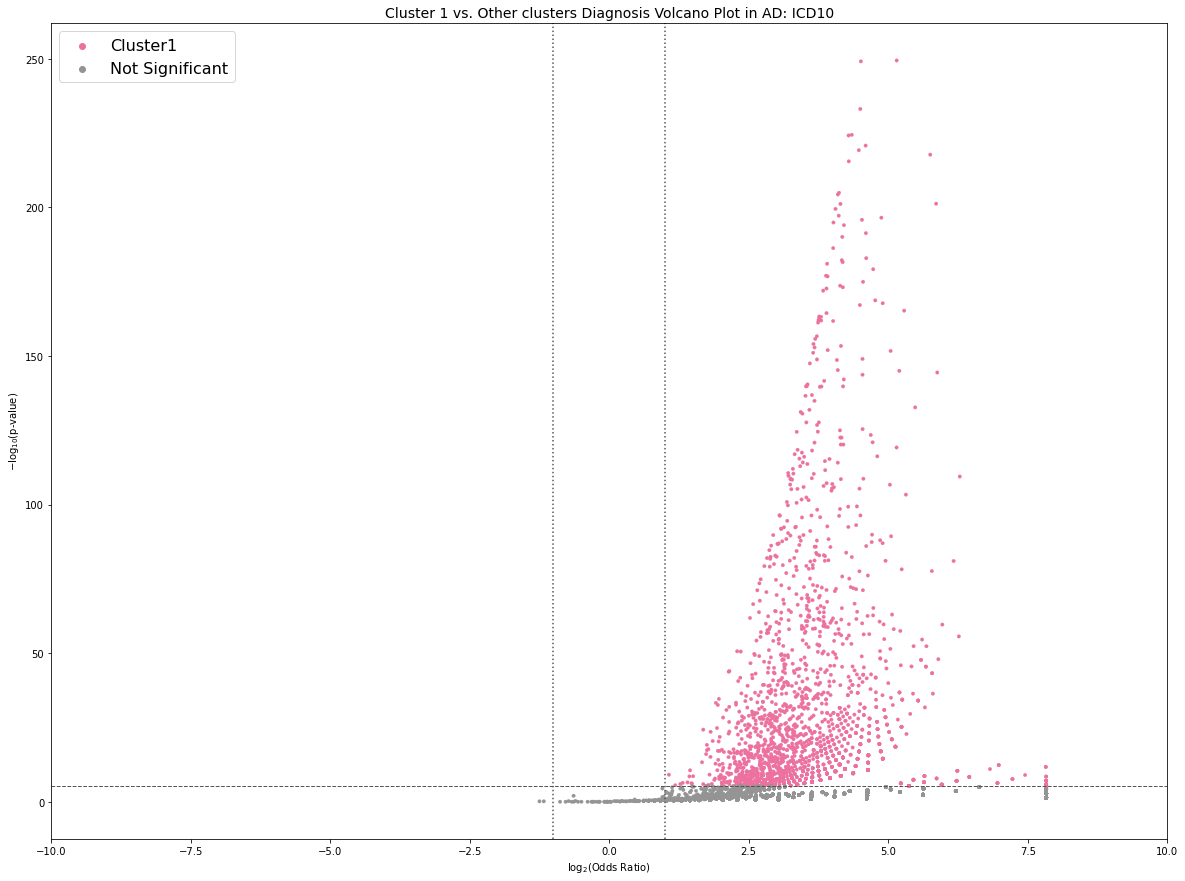

In [193]:

plot_diagkeys = ['ICD10']

# データフレームを保存するための辞書
label_data_dict = {}

for n in plot_diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()

    # プロットの設定
    fig, ax = plt.figure(figsize=(20, 15)), plt.gca()
    g = sns.scatterplot(data=df, x='log2_oddsratio', y='-log_pvalue', 
                        hue='sig', palette=custom_palette, 
                        edgecolor=None, s=12, ax=ax)
    
    plt.xlim([-10, 10])
    plt.axhline(-np.log10(bc), linestyle='--', color='#555555', linewidth=1)
    plt.axvline(1, color='#555555', linestyle=':')
    plt.axvline(-1, color='#555555', linestyle=':')
    plt.xlabel(r'$\log_2$(Odds Ratio)')
    plt.ylabel(r'$-\log_{10}$(p-value)')
    plt.legend(loc='upper left', prop={'size': 16})  # 凡例を左上に移動
    plt.title('Cluster 1 vs. Other clusters Diagnosis Volcano Plot in AD: ' + n, fontsize=14)
    

    plt.show()

# Cluster 2 vs Other Clusters

In [194]:
focus_cluster = 'Cluster_2'

In [195]:
alldiag_f_cluster = alldiag_cluster[alldiag_cluster[focus_cluster]==1]
alldiag_nonf_cluster = alldiag_cluster[alldiag_cluster[focus_cluster]==0]

In [196]:
alldiag_f_cluster['PatientID'].nunique()

538

In [197]:
alldiag_nonf_cluster['PatientID'].nunique()

7825

In [198]:
total_f = alldiag_f_cluster['PatientID'].nunique() #Total cluster0 patients
total_nonf = alldiag_nonf_cluster['PatientID'].nunique() #Total cluster1 patients

In [199]:
countDiagnosis_f = countPtsDiagnosis_Dict(alldiag_f_cluster, total_f)

In [200]:
countDiagnosis_nonf = countPtsDiagnosis_Dict(alldiag_nonf_cluster, total_nonf)

In [201]:
# Create dictionary of dataframes of contingency table for each diagnosis
alldiagcount = dict() 

jointype = 'outer' # outer join allows us to have contingency table with 0 as entries

for n in diagkeys:
    alldiagcount[n] = countDiagnosis_f[n].merge(countDiagnosis_nonf[n], how = jointype, on = n, suffixes=('_c2','_nonc2'))
    alldiagcount[n] = alldiagcount[n].set_index(n)
    if jointype == 'outer': # replace nan's
        nanreplace = dict(zip( list(alldiagcount[n].columns) , [0,total_f,0,total_nonf] ))
        alldiagcount[n] =  alldiagcount[n].fillna(value=nanreplace)

In [202]:
# compute p-values.
chitest_count = sigTestCountsDict(alldiagcount, diagkeys, verbose = 1, diag = True)

Significance testing on  DiagnosisName
DiagnosisName : Amount:  33031
	 Fisher Exact for <5 pts in a category, num: 30818
		 fisher: (30818, 2)
		 fisher1: (30818, 8)
	 Chi square for >=5 pts in a category, num: 2213
		 fisher (2213, 4)
		 chisquare: (2213, 9)
		 combined 1: (33031, 13)
		 combined 2: (33031, 14)
	 Final num:  33031
Significance testing on  l2_name
l2_name : Amount:  270
	 Fisher Exact for <5 pts in a category, num: 71
		 fisher: (71, 2)
		 fisher1: (71, 8)
	 Chi square for >=5 pts in a category, num: 199
		 fisher (199, 4)
		 chisquare: (199, 9)
		 combined 1: (270, 13)
		 combined 2: (270, 14)
	 Final num:  270
Significance testing on  ICD10
ICD10 : Amount:  10450
	 Fisher Exact for <5 pts in a category, num: 8768
		 fisher: (8768, 2)
		 fisher1: (8768, 8)
	 Chi square for >=5 pts in a category, num: 1682
		 fisher (1682, 4)
		 chisquare: (1682, 9)
		 combined 1: (10450, 13)
		 combined 2: (10450, 14)
	 Final num:  10450


In [203]:
# Categorize diagnosis based upon significance
for n in diagkeys:
    bc = .05/chitest_count[n].shape[0] # Bonferonni corrected p-value
    print('bc:',bc)
    
    sig = np.full(shape = (chitest_count[n].shape[0],), fill_value = 'Not Significant') 
    sig[chitest_count[n]['pvalue']<bc] = 'Significant'
    mask = (chitest_count[n]['pvalue']<bc) & (chitest_count[n]['log2_oddsratio']>1)
    sig[mask] = 'Cluster2'
    mask = (chitest_count[n]['pvalue']<bc) & (chitest_count[n]['log2_oddsratio']<-1)
    sig[mask] = 'Other Clusters'
    
    chitest_count[n]['sig'] = sig
    print(chitest_count[n]['sig'].value_counts())
    
    # Save the file as CSV
    chitest_count[n][(chitest_count[n]['sig'] != 'Not Significant')].to_csv(f'sig_diagnosis_stats_AD_c2_other_{n}_volcano.csv', index=True)

    
    print('\n')


bc: 1.51372952680815e-06
Not Significant    31773
Cluster2            1250
Other Clusters         7
Significant            1
Name: sig, dtype: int64


bc: 0.0001851851851851852
Cluster2           172
Not Significant     97
Significant          1
Name: sig, dtype: int64


bc: 4.784688995215312e-06
Not Significant    9463
Cluster2            983
Significant           4
Name: sig, dtype: int64




In [204]:
# save
import pickle 
pickle.dump(chitest_count, open('all_diagnosis_stats_c2_other_AD_volcano.picke', 'wb'))

In [205]:
# カスタムカラーマップの定義
custom_palette = {
    "Not Significant": "#949494",
    "Significant": "#51A0D5",
    "Cluster2": "#EC719E",
    "Other Clusters": "#2CB97C"
}

# カスタムカラーマップを使用するためのリスト
custom_colors = ["#949494", "#51A0D5", "#EC719E", "#2CB97C"]

In [206]:
# データフレームを保存するための辞書
label_data_dict = {}

for n in diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()
 
    # 統計的に有意を取得
    significant_df = df[df['sig'] != 'Not Significant'].copy()

    # ラベルデータを保存
    label_data = [
        {'Label': row['index'], 'X': row['log2_oddsratio'], 'Y': row['-log_pvalue']}
        for idx, row in significant_df.iterrows()
    ]

    # pandas DataFrameに変換
    df_labels = pd.DataFrame(label_data)

    df_labels.to_csv(f'c2_label_positions_AD_{n}_volcano.csv', index=False)

In [207]:
label_positions_df = pd.read_csv('c2_label_positions_AD_ICD10_volcano.csv')
mapping_df = pd.read_csv('ICD10_Disease_Mapping.csv')

In [208]:
# Initialize flag column with 0
label_positions_df['flag'] = 0

# Create a mapping column for the disease name
label_positions_df['mapping'] = ""


In [209]:
# Iterate through the labels and set flag to 1 and mapping to the disease name if partial match is found
for idx, row in label_positions_df.iterrows():
    for mapping_idx, mapping_row in mapping_df.iterrows():
        if mapping_row['ICD10_Code'] in row['Label']:  # Partial match check
            label_positions_df.at[idx, 'flag'] = 1
            label_positions_df.at[idx, 'mapping'] = mapping_row['Disease_Name']
            break

In [210]:
# First, filter the rows where flag is 1
flagged_df = label_positions_df[label_positions_df['flag'] == 1]

# Group by 'mapping' (Disease_Name), and for each group, find the row with the max 'X'
max_X_idx = flagged_df.groupby('mapping')['X'].idxmax()

# Now, update the flag in the original DataFrame
# First, set all flags to 0 for rows where flag is currently 1
label_positions_df.loc[label_positions_df['flag'] == 1, 'flag'] = 0

# Set flag to 1 for the rows with the max 'X' in each group
label_positions_df.loc[max_X_idx, 'flag'] = 1

In [211]:
flagged_df = label_positions_df[label_positions_df['flag'] == 1]

# Sort the flagged rows by 'X' in descending order and get the top 10
top_10_idx = flagged_df.nlargest(10, 'X').index

# Now, update the flag in the original DataFrame
# First, set all flags to 0 for rows where flag is currently 1
label_positions_df.loc[label_positions_df['flag'] == 1, 'flag'] = 0

# Set flag to 1 for the top 10 rows with the largest 'X' values
label_positions_df.loc[top_10_idx, 'flag'] = 1

In [212]:
label_positions_df.to_csv(f'c2_label_positions_AD_ICD10_volcano.csv', index=False)

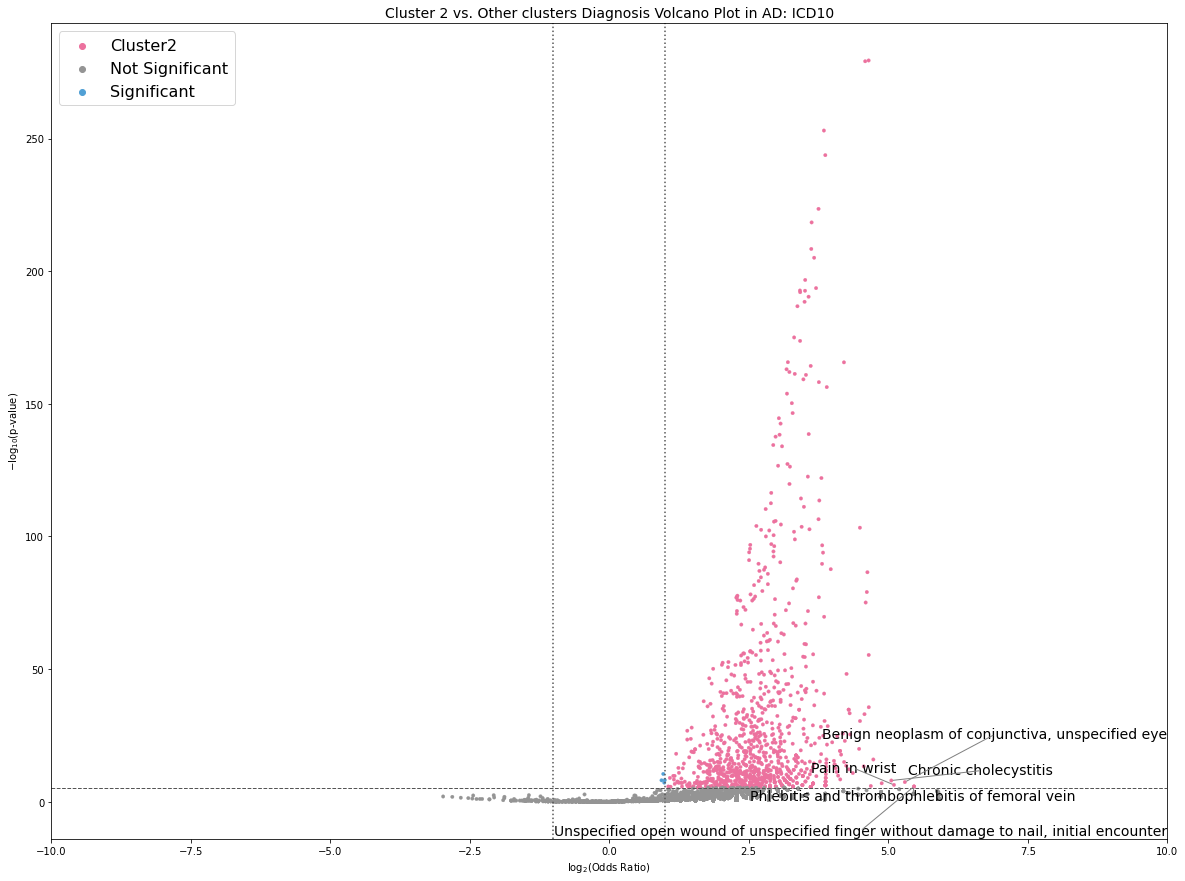

In [213]:
# マッピングファイルを読み込む
df_labels = pd.read_csv('c2_label_positions_AD_ICD10_map.csv')

plot_diagkeys = ['ICD10']

# データフレームを保存するための辞書
label_data_dict = {}

for n in plot_diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()

    # プロットの設定
    fig, ax = plt.figure(figsize=(20, 15)), plt.gca()
    g = sns.scatterplot(data=df, x='log2_oddsratio', y='-log_pvalue', 
                        hue='sig', palette=custom_palette, 
                        edgecolor=None, s=12, ax=ax)
    
    plt.xlim([-10, 10])
    plt.axhline(-np.log10(bc), linestyle='--', color='#555555', linewidth=1)
    plt.axvline(1, color='#555555', linestyle=':')
    plt.axvline(-1, color='#555555', linestyle=':')
    plt.xlabel(r'$\log_2$(Odds Ratio)')
    plt.ylabel(r'$-\log_{10}$(p-value)')
    plt.legend(loc='upper left', prop={'size': 16})  # 凡例を左上に移動
    plt.title('Cluster 2 vs. Other clusters Diagnosis Volcano Plot in AD: ' + n, fontsize=14)
    
    # 保存されたラベルを再プロット
    texts = []
    for idx, row in df_labels.iterrows():
        if row['flag'] == 1:
            label_text = row['mapping']
            x_pos = row['X']
            y_pos = row['Y']
        
            # テキストラベルを再度プロット (フォントサイズを少し小さく)
            text = ax.text(x_pos, y_pos, label_text, fontsize=14, ha='left', va='center')
            texts.append(text)

    # adjustTextでラベルの重なりを解消 (X方向にも動かすように変更)
    adjust_text(texts, 
                only_move={'points': 'xy', 'text': 'xy'},  # X方向とY方向両方に移動
                arrowprops=dict(arrowstyle='-', color='gray', lw=1.0),  # ラベルからポイントに矢印を描画
                expand_points=(1.3, 1.3),  # ポイント周りのスペースを広げる
                expand_text=(1.3, 1.3),  # テキスト周りのスペースを広げる
                force_text=2.0,  # ラベルをより大きく移動させる
                force_points=1.5,  # ポイントも少し動かす
                lim_points_text=1.5,  # ポイントとテキストの最小距離を増やす
                lim_text_text=2.0,  # テキスト同士の最小距離を増やす
                avoid_self=True,  # 自分自身との重なりを避ける
                ensure_inside_axes=True)  # プロット内に収めるようにする

    plt.show()

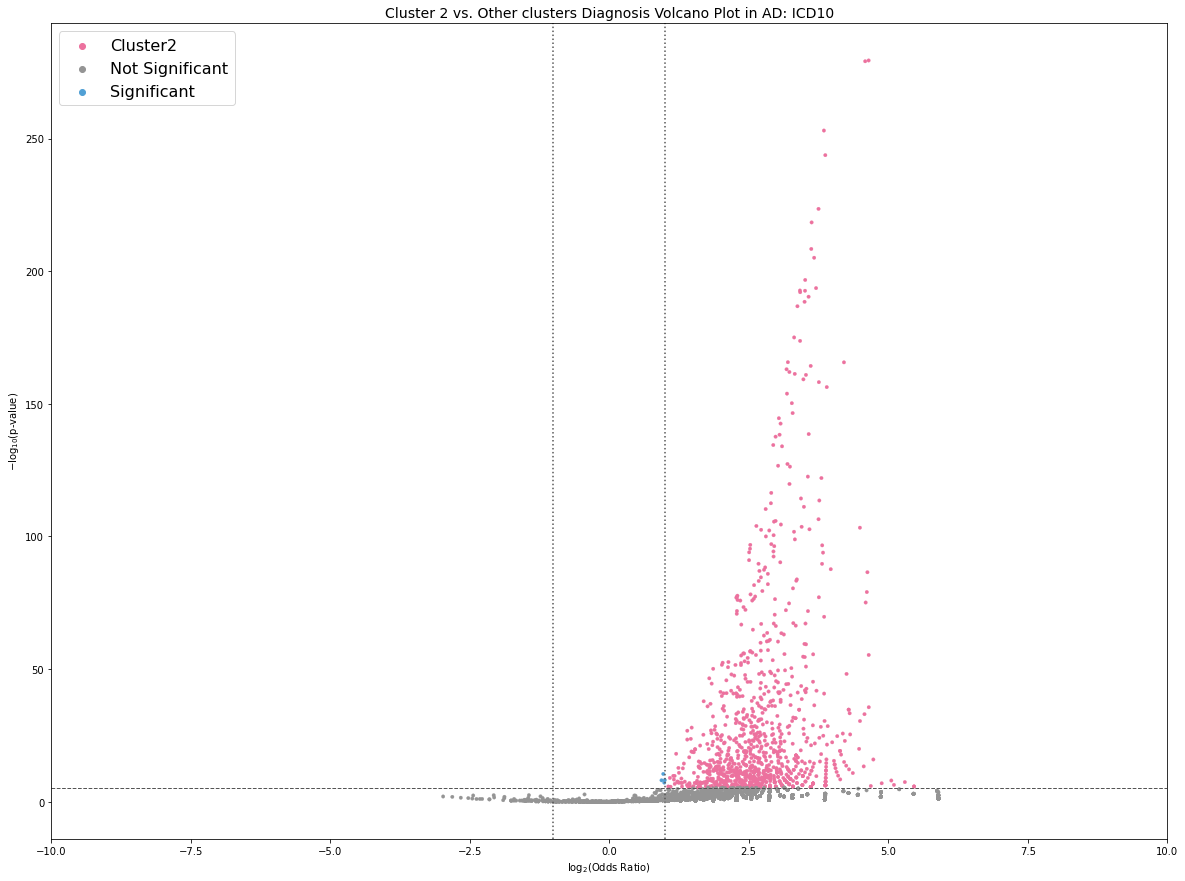

In [214]:

plot_diagkeys = ['ICD10']

# データフレームを保存するための辞書
label_data_dict = {}

for n in plot_diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()

    # プロットの設定
    fig, ax = plt.figure(figsize=(20, 15)), plt.gca()
    g = sns.scatterplot(data=df, x='log2_oddsratio', y='-log_pvalue', 
                        hue='sig', palette=custom_palette, 
                        edgecolor=None, s=12, ax=ax)
    
    plt.xlim([-10, 10])
    plt.axhline(-np.log10(bc), linestyle='--', color='#555555', linewidth=1)
    plt.axvline(1, color='#555555', linestyle=':')
    plt.axvline(-1, color='#555555', linestyle=':')
    plt.xlabel(r'$\log_2$(Odds Ratio)')
    plt.ylabel(r'$-\log_{10}$(p-value)')
    plt.legend(loc='upper left', prop={'size': 16})  # 凡例を左上に移動
    plt.title('Cluster 2 vs. Other clusters Diagnosis Volcano Plot in AD: ' + n, fontsize=14)
    

    plt.show()

# Cluster 3 vs Other Clusters

In [215]:
focus_cluster = 'Cluster_3'

In [216]:
alldiag_f_cluster = alldiag_cluster[alldiag_cluster[focus_cluster]==1]
alldiag_nonf_cluster = alldiag_cluster[alldiag_cluster[focus_cluster]==0]

In [217]:
alldiag_f_cluster['PatientID'].nunique()

815

In [218]:
alldiag_nonf_cluster['PatientID'].nunique()

7548

In [219]:
total_f = alldiag_f_cluster['PatientID'].nunique() #Total cluster0 patients
total_nonf = alldiag_nonf_cluster['PatientID'].nunique() #Total cluster1 patients

In [220]:
countDiagnosis_f = countPtsDiagnosis_Dict(alldiag_f_cluster, total_f)

In [221]:
countDiagnosis_nonf = countPtsDiagnosis_Dict(alldiag_nonf_cluster, total_nonf)

In [222]:
# Create dictionary of dataframes of contingency table for each diagnosis
alldiagcount = dict() 

jointype = 'outer' # outer join allows us to have contingency table with 0 as entries

for n in diagkeys:
    alldiagcount[n] = countDiagnosis_f[n].merge(countDiagnosis_nonf[n], how = jointype, on = n, suffixes=('_c3','_nonc3'))
    alldiagcount[n] = alldiagcount[n].set_index(n)
    if jointype == 'outer': # replace nan's
        nanreplace = dict(zip( list(alldiagcount[n].columns) , [0,total_f,0,total_nonf] ))
        alldiagcount[n] =  alldiagcount[n].fillna(value=nanreplace)

In [223]:
# compute p-values.
chitest_count = sigTestCountsDict(alldiagcount, diagkeys, verbose = 1, diag = True)

Significance testing on  DiagnosisName
DiagnosisName : Amount:  33031
	 Fisher Exact for <5 pts in a category, num: 30033
		 fisher: (30033, 2)
		 fisher1: (30033, 8)
	 Chi square for >=5 pts in a category, num: 2998
		 fisher (2998, 4)
		 chisquare: (2998, 9)
		 combined 1: (33031, 13)
		 combined 2: (33031, 14)
	 Final num:  33031
Significance testing on  l2_name
l2_name : Amount:  270
	 Fisher Exact for <5 pts in a category, num: 70
		 fisher: (70, 2)
		 fisher1: (70, 8)
	 Chi square for >=5 pts in a category, num: 200
		 fisher (200, 4)
		 chisquare: (200, 9)
		 combined 1: (270, 13)
		 combined 2: (270, 14)
	 Final num:  270
Significance testing on  ICD10
ICD10 : Amount:  10450
	 Fisher Exact for <5 pts in a category, num: 8592
		 fisher: (8592, 2)
		 fisher1: (8592, 8)
	 Chi square for >=5 pts in a category, num: 1858
		 fisher (1858, 4)
		 chisquare: (1858, 9)
		 combined 1: (10450, 13)
		 combined 2: (10450, 14)
	 Final num:  10450


In [224]:
# Categorize diagnosis based upon significance
for n in diagkeys:
    bc = .05/chitest_count[n].shape[0] # Bonferonni corrected p-value
    print('bc:',bc)
    
    sig = np.full(shape = (chitest_count[n].shape[0],), fill_value = 'Not Significant') 
    sig[chitest_count[n]['pvalue']<bc] = 'Significant'
    mask = (chitest_count[n]['pvalue']<bc) & (chitest_count[n]['log2_oddsratio']>1)
    sig[mask] = 'Cluster3'
    mask = (chitest_count[n]['pvalue']<bc) & (chitest_count[n]['log2_oddsratio']<-1)
    sig[mask] = 'Other Clusters'
    
    chitest_count[n]['sig'] = sig
    print(chitest_count[n]['sig'].value_counts())
    
    # Save the file as CSV
    chitest_count[n][(chitest_count[n]['sig'] != 'Not Significant')].to_csv(f'sig_diagnosis_stats_AD_c3_other_{n}_volcano.csv', index=True)

    
    print('\n')


bc: 1.51372952680815e-06
Not Significant    31776
Cluster3            1234
Other Clusters        15
Significant            6
Name: sig, dtype: int64


bc: 0.0001851851851851852
Not Significant    144
Cluster3           102
Significant         24
Name: sig, dtype: int64


bc: 4.784688995215312e-06
Not Significant    9768
Cluster3            655
Significant          25
Other Clusters        2
Name: sig, dtype: int64




In [225]:
# save
import pickle 
pickle.dump(chitest_count, open('all_diagnosis_stats_c3_other_AD_volcano.picke', 'wb'))

In [226]:
# カスタムカラーマップの定義
custom_palette = {
    "Not Significant": "#949494",
    "Significant": "#51A0D5",
    "Cluster3": "#EC719E",
    "Other Clusters": "#2CB97C"
}

# カスタムカラーマップを使用するためのリスト
custom_colors = ["#949494", "#51A0D5", "#EC719E", "#2CB97C"]

In [227]:
# データフレームを保存するための辞書
label_data_dict = {}

for n in diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()
 
    # 統計的に有意を取得
    significant_df = df[df['sig'] != 'Not Significant'].copy()

    # ラベルデータを保存
    label_data = [
        {'Label': row['index'], 'X': row['log2_oddsratio'], 'Y': row['-log_pvalue']}
        for idx, row in significant_df.iterrows()
    ]

    # pandas DataFrameに変換
    df_labels = pd.DataFrame(label_data)

    df_labels.to_csv(f'c3_label_positions_AD_{n}_volcano.csv', index=False)

In [228]:
label_positions_df = pd.read_csv('c3_label_positions_AD_ICD10_volcano.csv')
mapping_df = pd.read_csv('ICD10_Disease_Mapping.csv')

In [229]:
# Initialize flag column with 0
label_positions_df['flag'] = 0

# Create a mapping column for the disease name
label_positions_df['mapping'] = ""


In [230]:
# Iterate through the labels and set flag to 1 and mapping to the disease name if partial match is found
for idx, row in label_positions_df.iterrows():
    for mapping_idx, mapping_row in mapping_df.iterrows():
        if mapping_row['ICD10_Code'] in row['Label']:  # Partial match check
            label_positions_df.at[idx, 'flag'] = 1
            label_positions_df.at[idx, 'mapping'] = mapping_row['Disease_Name']
            break

In [231]:
# First, filter the rows where flag is 1
flagged_df = label_positions_df[label_positions_df['flag'] == 1]

# Group by 'mapping' (Disease_Name), and for each group, find the row with the max 'X'
max_X_idx = flagged_df.groupby('mapping')['X'].idxmax()

# Now, update the flag in the original DataFrame
# First, set all flags to 0 for rows where flag is currently 1
label_positions_df.loc[label_positions_df['flag'] == 1, 'flag'] = 0

# Set flag to 1 for the rows with the max 'X' in each group
label_positions_df.loc[max_X_idx, 'flag'] = 1

In [232]:
flagged_df = label_positions_df[label_positions_df['flag'] == 1]

# Sort the flagged rows by 'X' in descending order and get the top 10
top_10_idx = flagged_df.nlargest(10, 'X').index

# Now, update the flag in the original DataFrame
# First, set all flags to 0 for rows where flag is currently 1
label_positions_df.loc[label_positions_df['flag'] == 1, 'flag'] = 0

# Set flag to 1 for the top 10 rows with the largest 'X' values
label_positions_df.loc[top_10_idx, 'flag'] = 1

In [233]:
label_positions_df.to_csv(f'c3_label_positions_AD_ICD10_volcano.csv', index=False)

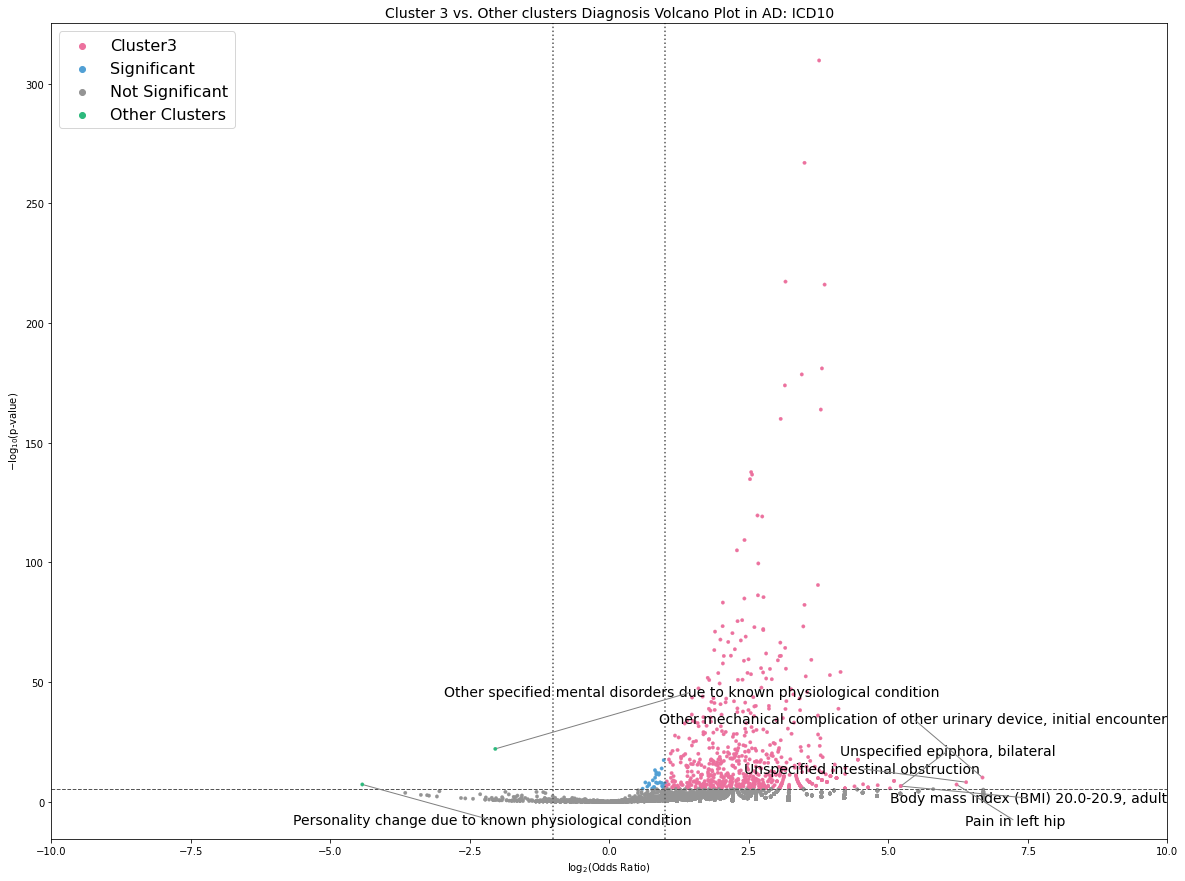

In [234]:
# マッピングファイルを読み込む
df_labels = pd.read_csv('c3_label_positions_AD_ICD10_map.csv')

plot_diagkeys = ['ICD10']

# データフレームを保存するための辞書
label_data_dict = {}

for n in plot_diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()

    # プロットの設定
    fig, ax = plt.figure(figsize=(20, 15)), plt.gca()
    g = sns.scatterplot(data=df, x='log2_oddsratio', y='-log_pvalue', 
                        hue='sig', palette=custom_palette, 
                        edgecolor=None, s=12, ax=ax)
    
    plt.xlim([-10, 10])
    plt.axhline(-np.log10(bc), linestyle='--', color='#555555', linewidth=1)
    plt.axvline(1, color='#555555', linestyle=':')
    plt.axvline(-1, color='#555555', linestyle=':')
    plt.xlabel(r'$\log_2$(Odds Ratio)')
    plt.ylabel(r'$-\log_{10}$(p-value)')
    plt.legend(loc='upper left', prop={'size': 16})  # 凡例を左上に移動
    plt.title('Cluster 3 vs. Other clusters Diagnosis Volcano Plot in AD: ' + n, fontsize=14)
    
    # 保存されたラベルを再プロット
    texts = []
    for idx, row in df_labels.iterrows():
        if row['flag'] == 1:
            label_text = row['mapping']
            x_pos = row['X']
            y_pos = row['Y']
        
            # テキストラベルを再度プロット (フォントサイズを少し小さく)
            text = ax.text(x_pos, y_pos, label_text, fontsize=14, ha='left', va='center')
            texts.append(text)

    # adjustTextでラベルの重なりを解消 (X方向にも動かすように変更)
    adjust_text(texts, 
                only_move={'points': 'xy', 'text': 'xy'},  # X方向とY方向両方に移動
                arrowprops=dict(arrowstyle='-', color='gray', lw=1.0),  # ラベルからポイントに矢印を描画
                expand_points=(1.3, 1.3),  # ポイント周りのスペースを広げる
                expand_text=(1.3, 1.3),  # テキスト周りのスペースを広げる
                force_text=2.0,  # ラベルをより大きく移動させる
                force_points=1.5,  # ポイントも少し動かす
                lim_points_text=1.5,  # ポイントとテキストの最小距離を増やす
                lim_text_text=2.0,  # テキスト同士の最小距離を増やす
                avoid_self=True,  # 自分自身との重なりを避ける
                ensure_inside_axes=True)  # プロット内に収めるようにする

    plt.show()


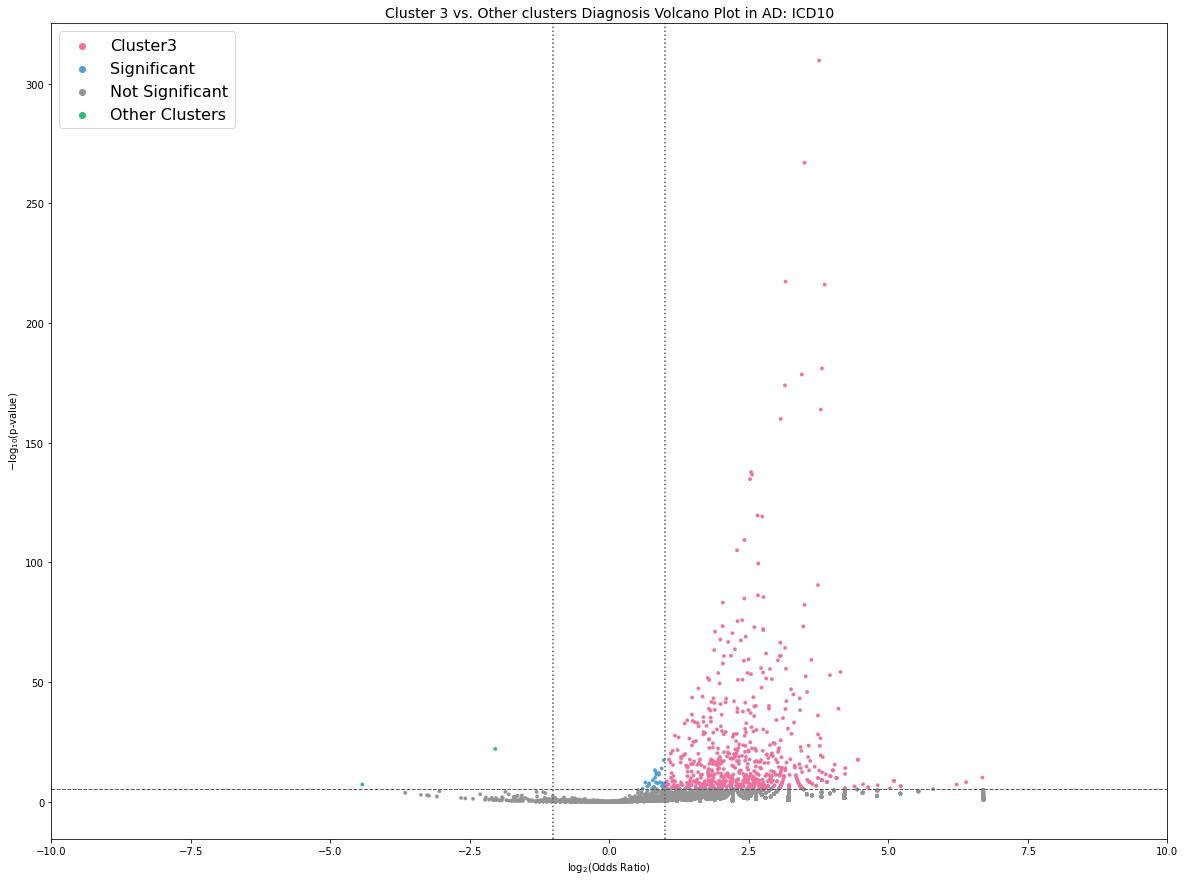

In [235]:

plot_diagkeys = ['ICD10']

# データフレームを保存するための辞書
label_data_dict = {}

for n in plot_diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()

    # プロットの設定
    fig, ax = plt.figure(figsize=(20, 15)), plt.gca()
    g = sns.scatterplot(data=df, x='log2_oddsratio', y='-log_pvalue', 
                        hue='sig', palette=custom_palette, 
                        edgecolor=None, s=12, ax=ax)
    
    plt.xlim([-10, 10])
    plt.axhline(-np.log10(bc), linestyle='--', color='#555555', linewidth=1)
    plt.axvline(1, color='#555555', linestyle=':')
    plt.axvline(-1, color='#555555', linestyle=':')
    plt.xlabel(r'$\log_2$(Odds Ratio)')
    plt.ylabel(r'$-\log_{10}$(p-value)')
    plt.legend(loc='upper left', prop={'size': 16})  # 凡例を左上に移動
    plt.title('Cluster 3 vs. Other clusters Diagnosis Volcano Plot in AD: ' + n, fontsize=14)
    
    plt.show()

# Cluster 4 vs Other Clusters

In [236]:
focus_cluster = 'Cluster_4'

In [237]:
alldiag_f_cluster = alldiag_cluster[alldiag_cluster[focus_cluster]==1]
alldiag_nonf_cluster = alldiag_cluster[alldiag_cluster[focus_cluster]==0]

In [238]:
alldiag_f_cluster['PatientID'].nunique()

1521

In [239]:
alldiag_nonf_cluster['PatientID'].nunique()

6842

In [240]:
total_f = alldiag_f_cluster['PatientID'].nunique() #Total cluster0 patients
total_nonf = alldiag_nonf_cluster['PatientID'].nunique() #Total cluster1 patients

In [241]:
countDiagnosis_f = countPtsDiagnosis_Dict(alldiag_f_cluster, total_f)

In [242]:
countDiagnosis_nonf = countPtsDiagnosis_Dict(alldiag_nonf_cluster, total_nonf)

In [243]:
# Create dictionary of dataframes of contingency table for each diagnosis
alldiagcount = dict() 

jointype = 'outer' # outer join allows us to have contingency table with 0 as entries

for n in diagkeys:
    alldiagcount[n] = countDiagnosis_f[n].merge(countDiagnosis_nonf[n], how = jointype, on = n, suffixes=('_c4','_nonc4'))
    alldiagcount[n] = alldiagcount[n].set_index(n)
    if jointype == 'outer': # replace nan's
        nanreplace = dict(zip( list(alldiagcount[n].columns) , [0,total_f,0,total_nonf] ))
        alldiagcount[n] =  alldiagcount[n].fillna(value=nanreplace)

In [244]:
# compute p-values.
chitest_count = sigTestCountsDict(alldiagcount, diagkeys, verbose = 1, diag = True)

Significance testing on  DiagnosisName
DiagnosisName : Amount:  33031
	 Fisher Exact for <5 pts in a category, num: 31039
		 fisher: (31039, 2)
		 fisher1: (31039, 8)
	 Chi square for >=5 pts in a category, num: 1992
		 fisher (1992, 4)
		 chisquare: (1992, 9)
		 combined 1: (33031, 13)
		 combined 2: (33031, 14)
	 Final num:  33031
Significance testing on  l2_name
l2_name : Amount:  270
	 Fisher Exact for <5 pts in a category, num: 69
		 fisher: (69, 2)
		 fisher1: (69, 8)
	 Chi square for >=5 pts in a category, num: 201
		 fisher (201, 4)
		 chisquare: (201, 9)
		 combined 1: (270, 13)
		 combined 2: (270, 14)
	 Final num:  270
Significance testing on  ICD10
ICD10 : Amount:  10450
	 Fisher Exact for <5 pts in a category, num: 8882
		 fisher: (8882, 2)
		 fisher1: (8882, 8)
	 Chi square for >=5 pts in a category, num: 1568
		 fisher (1568, 4)
		 chisquare: (1568, 9)
		 combined 1: (10450, 13)
		 combined 2: (10450, 14)
	 Final num:  10450


In [245]:
# Categorize diagnosis based upon significance
for n in diagkeys:
    bc = .05/chitest_count[n].shape[0] # Bonferonni corrected p-value
    print('bc:',bc)
    
    sig = np.full(shape = (chitest_count[n].shape[0],), fill_value = 'Not Significant') 
    sig[chitest_count[n]['pvalue']<bc] = 'Significant'
    mask = (chitest_count[n]['pvalue']<bc) & (chitest_count[n]['log2_oddsratio']>1)
    sig[mask] = 'Cluster4'
    mask = (chitest_count[n]['pvalue']<bc) & (chitest_count[n]['log2_oddsratio']<-1)
    sig[mask] = 'Other Clusters'
    
    chitest_count[n]['sig'] = sig
    print(chitest_count[n]['sig'].value_counts())
    
    # Save the file as CSV
    chitest_count[n][(chitest_count[n]['sig'] != 'Not Significant')].to_csv(f'sig_diagnosis_stats_AD_c4_other_{n}_volcano.csv', index=True)

    
    print('\n')


bc: 1.51372952680815e-06
Not Significant    32568
Other Clusters       235
Cluster4             203
Significant           25
Name: sig, dtype: int64


bc: 0.0001851851851851852
Not Significant    186
Significant         60
Cluster4            21
Other Clusters       3
Name: sig, dtype: int64


bc: 4.784688995215312e-06
Not Significant    10195
Cluster4             127
Other Clusters        77
Significant           51
Name: sig, dtype: int64




In [246]:
# save
import pickle 
pickle.dump(chitest_count, open('all_diagnosis_stats_c4_other_AD_volcano.picke', 'wb'))

In [247]:
# カスタムカラーマップの定義
custom_palette = {
    "Not Significant": "#949494",
    "Significant": "#51A0D5",
    "Cluster4": "#EC719E",
    "Other Clusters": "#2CB97C"
}

# カスタムカラーマップを使用するためのリスト
custom_colors = ["#949494", "#51A0D5", "#EC719E", "#2CB97C"]

In [248]:
# データフレームを保存するための辞書
label_data_dict = {}

for n in diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()
 
    # 統計的に有意を取得
    significant_df = df[df['sig'] != 'Not Significant'].copy()

    # ラベルデータを保存
    label_data = [
        {'Label': row['index'], 'X': row['log2_oddsratio'], 'Y': row['-log_pvalue']}
        for idx, row in significant_df.iterrows()
    ]

    # pandas DataFrameに変換
    df_labels = pd.DataFrame(label_data)

    df_labels.to_csv(f'c4_label_positions_AD_{n}_volcano.csv', index=False)

In [249]:
label_positions_df = pd.read_csv('c4_label_positions_AD_ICD10_volcano.csv')
mapping_df = pd.read_csv('ICD10_Disease_Mapping.csv')

In [250]:
# Initialize flag column with 0
label_positions_df['flag'] = 0

# Create a mapping column for the disease name
label_positions_df['mapping'] = ""


In [251]:
# Iterate through the labels and set flag to 1 and mapping to the disease name if partial match is found
for idx, row in label_positions_df.iterrows():
    for mapping_idx, mapping_row in mapping_df.iterrows():
        if mapping_row['ICD10_Code'] in row['Label']:  # Partial match check
            label_positions_df.at[idx, 'flag'] = 1
            label_positions_df.at[idx, 'mapping'] = mapping_row['Disease_Name']
            break

In [252]:
# First, filter the rows where flag is 1
flagged_df = label_positions_df[label_positions_df['flag'] == 1]

# Group by 'mapping' (Disease_Name), and for each group, find the row with the max 'X'
max_X_idx = flagged_df.groupby('mapping')['X'].idxmax()

# Now, update the flag in the original DataFrame
# First, set all flags to 0 for rows where flag is currently 1
label_positions_df.loc[label_positions_df['flag'] == 1, 'flag'] = 0

# Set flag to 1 for the rows with the max 'X' in each group
label_positions_df.loc[max_X_idx, 'flag'] = 1

In [253]:
flagged_df = label_positions_df[label_positions_df['flag'] == 1]

# Sort the flagged rows by 'X' in descending order and get the top 10
top_10_idx = flagged_df.nlargest(10, 'X').index

# Now, update the flag in the original DataFrame
# First, set all flags to 0 for rows where flag is currently 1
label_positions_df.loc[label_positions_df['flag'] == 1, 'flag'] = 0

# Set flag to 1 for the top 10 rows with the largest 'X' values
label_positions_df.loc[top_10_idx, 'flag'] = 1

In [254]:
label_positions_df.to_csv(f'c4_label_positions_AD_ICD10_volcano.csv', index=False)

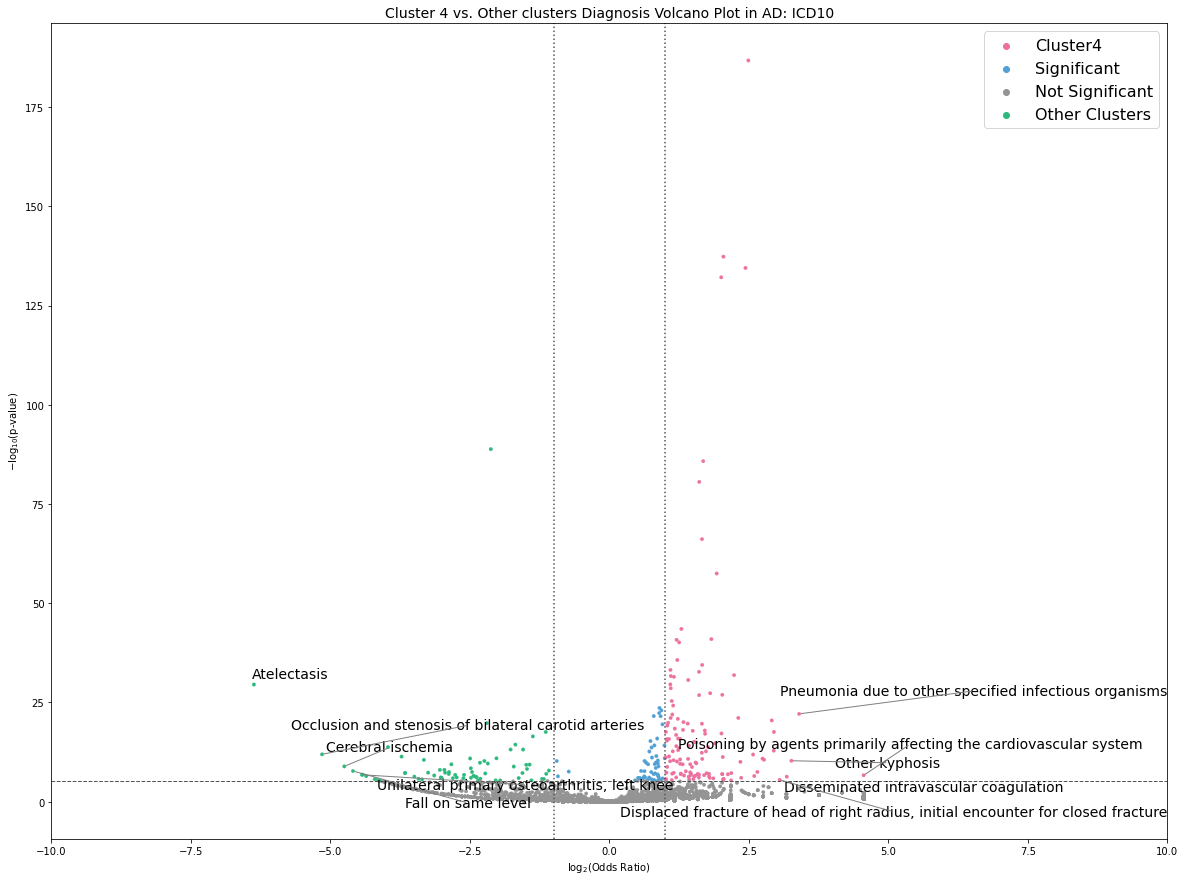

In [255]:
# マッピングファイルを読み込む
df_labels = pd.read_csv('c4_label_positions_AD_ICD10_map.csv')

plot_diagkeys = ['ICD10']

# データフレームを保存するための辞書
label_data_dict = {}

for n in plot_diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()

    # プロットの設定
    fig, ax = plt.figure(figsize=(20, 15)), plt.gca()
    g = sns.scatterplot(data=df, x='log2_oddsratio', y='-log_pvalue', 
                        hue='sig', palette=custom_palette, 
                        edgecolor=None, s=12, ax=ax)
    
    plt.xlim([-10, 10])
    plt.axhline(-np.log10(bc), linestyle='--', color='#555555', linewidth=1)
    plt.axvline(1, color='#555555', linestyle=':')
    plt.axvline(-1, color='#555555', linestyle=':')
    plt.xlabel(r'$\log_2$(Odds Ratio)')
    plt.ylabel(r'$-\log_{10}$(p-value)')
    plt.legend(loc='upper right', prop={'size': 16})  # 凡例を左上に移動
    plt.title('Cluster 4 vs. Other clusters Diagnosis Volcano Plot in AD: ' + n, fontsize=14)
    
    # 保存されたラベルを再プロット
    texts = []
    for idx, row in df_labels.iterrows():
        if row['flag'] == 1:
            label_text = row['mapping']
            x_pos = row['X']
            y_pos = row['Y']
        
            # テキストラベルを再度プロット (フォントサイズを少し小さく)
            text = ax.text(x_pos, y_pos, label_text, fontsize=14, ha='left', va='center')
            texts.append(text)

    # adjustTextでラベルの重なりを解消 (X方向にも動かすように変更)
    adjust_text(texts, 
                only_move={'points': 'xy', 'text': 'xy'},  # X方向とY方向両方に移動
                arrowprops=dict(arrowstyle='-', color='gray', lw=1.0),  # ラベルからポイントに矢印を描画
                expand_points=(1.3, 1.3),  # ポイント周りのスペースを広げる
                expand_text=(1.3, 1.3),  # テキスト周りのスペースを広げる
                force_text=2.0,  # ラベルをより大きく移動させる
                force_points=1.5,  # ポイントも少し動かす
                lim_points_text=1.5,  # ポイントとテキストの最小距離を増やす
                lim_text_text=2.0,  # テキスト同士の最小距離を増やす
                avoid_self=True,  # 自分自身との重なりを避ける
                ensure_inside_axes=True)  # プロット内に収めるようにする

    plt.show()


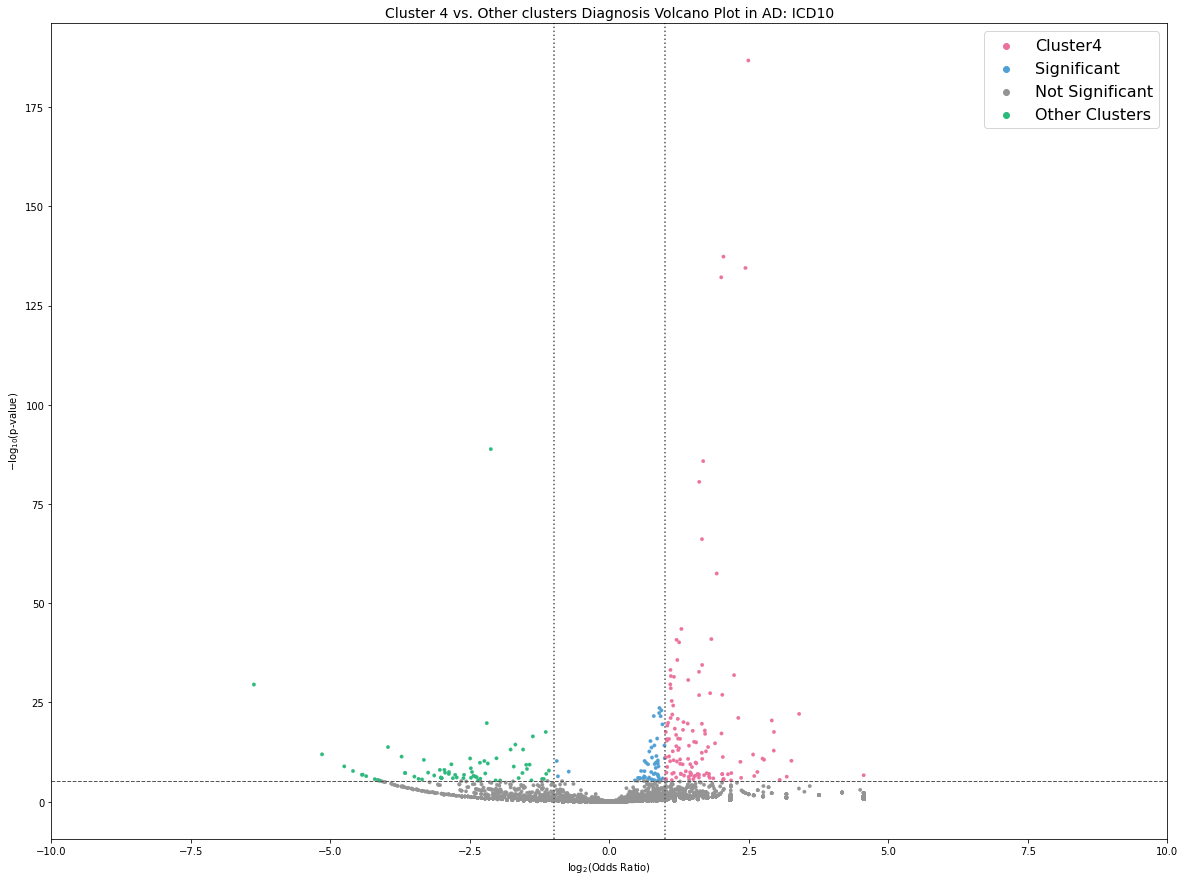

In [256]:

plot_diagkeys = ['ICD10']

# データフレームを保存するための辞書
label_data_dict = {}

for n in plot_diagkeys:
    bc = .05 / chitest_count[n].shape[0]
    chitest_count[n]['index'] = chitest_count[n].index
    df = chitest_count[n].copy()

    # プロットの設定
    fig, ax = plt.figure(figsize=(20, 15)), plt.gca()
    g = sns.scatterplot(data=df, x='log2_oddsratio', y='-log_pvalue', 
                        hue='sig', palette=custom_palette, 
                        edgecolor=None, s=12, ax=ax)
    
    plt.xlim([-10, 10])
    plt.axhline(-np.log10(bc), linestyle='--', color='#555555', linewidth=1)
    plt.axvline(1, color='#555555', linestyle=':')
    plt.axvline(-1, color='#555555', linestyle=':')
    plt.xlabel(r'$\log_2$(Odds Ratio)')
    plt.ylabel(r'$-\log_{10}$(p-value)')
    plt.legend(loc='upper right', prop={'size': 16})  # 凡例を左上に移動
    plt.title('Cluster 4 vs. Other clusters Diagnosis Volcano Plot in AD: ' + n, fontsize=14)


    plt.show()
